Blatently stolen from.
https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split 
from sklearn import metrics   #Additional scklearn functions
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier

%matplotlib inline

In [47]:
filename = 'KaggleV2-May-2016.csv'
dd = pd.read_csv(filename, encoding='latin')

lb_Encoder = LabelEncoder()
dd['Neighbourhood_category'] = lb_Encoder.fit_transform(dd['Neighbourhood'])
dd['Gender_category'] = lb_Encoder.fit_transform(dd['Gender'])
dd['no_show'] = dd['No-show'] == 'Yes'



dd['ScheduledDay'] = dd.ScheduledDay.apply(lambda x: x.strip('Z')).apply(lambda x: x.replace('T', ' '))
dd['ScheduledDay'] = pd.to_datetime(dd['ScheduledDay'])
dd['AppointmentDay'] = dd.AppointmentDay.apply(lambda x: x.strip('Z')).apply(lambda x: x.replace('T', ' '))
dd['AppointmentDay'] = pd.to_datetime(dd['AppointmentDay'])

dd['time_d'] = dd['AppointmentDay'] - dd['ScheduledDay']
dd['time_d_total_seconds'] = dd.time_d.apply(lambda x: x.total_seconds())
dd['time_d_total_days'] = dd['time_d_total_seconds']/(24.0*60.0*60.0)
dd['time_d_total_days'] = dd['time_d_total_days'].astype(int)

dd['a_day_of_week'] = dd.AppointmentDay.apply(lambda x: x.dayofweek)
dd['s_day_of_week'] = dd.ScheduledDay.apply(lambda x: x.dayofweek)

dd.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,...,SMS_received,No-show,Neighbourhood_category,Gender_category,no_show,time_d,time_d_total_seconds,time_d_total_days,a_day_of_week,s_day_of_week
0,2.987250e+13,5642903,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,...,0,No,39,0,False,-1 days +05:21:52,-67088.0,0,4,4
1,5.589980e+14,5642503,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,...,0,No,39,1,False,-1 days +07:51:33,-58107.0,0,4,4
2,4.262960e+12,5642549,F,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,...,0,No,45,0,False,-1 days +07:40:56,-58744.0,0,4,4
3,8.679510e+11,5642828,F,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,...,0,No,54,0,False,-1 days +06:30:29,-62971.0,0,4,4
4,8.841190e+12,5642494,F,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,...,0,No,39,0,False,-1 days +07:52:37,-58043.0,0,4,4


In [48]:
def modelfit(alg, dtrain, predictors, output, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[output])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, dtrain[predictors], dtrain[output], cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print("Model Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain[output].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[output], dtrain_predprob))
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        plt.show()

In [49]:
def plot_roc(classifier, data, predictors, output):
    X = data.as_matrix(columns=predictors)
    y = data[output]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)  #can use a smaller test size because decent data set size

    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)
    y_proba = classifier.predict_proba(X_test)
    
    misclassified_points = (y_test != y_pred).sum()
    accuracy = (X_test.shape[0] - float(misclassified_points)) / X_test.shape[0]*100
    fpr, tpr, _ = roc_curve(y_test, y_proba[:,1])
    auc = roc_auc_score(y_test, y_proba[:,1])
    print("Accuracy = ", accuracy)
    print("AUC = ", auc)

    plt.clf()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.show()

Model Report
Accuracy : 0.7985
AUC Score (Train): 0.728561
CV Score : Mean - 0.7115958 | Std - 0.01419153 | Min - 0.6845538 | Max - 0.7254504


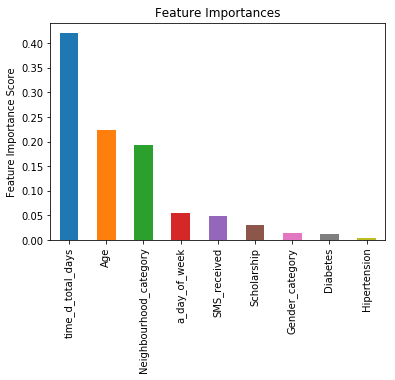

In [50]:
#Choose all predictors except target & IDcols
feature_set  =['Age', 'SMS_received', 'Neighbourhood_category' ,'Scholarship', 'Hipertension', 'Diabetes', 'a_day_of_week', 'Gender_category', 'time_d_total_days']

gbm0 = GradientBoostingClassifier(random_state=10)
modelfit(gbm0, dd, feature_set, 'no_show')


In [51]:
param_test1 = {'n_estimators':range(20,81,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), 
param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
print(gsearch1.fit(dd[feature_set],dd['no_show']))
print("CV_results ", gsearch1.cv_results_)
print("Best params ", gsearch1.best_params_)
print("Best score ", gsearch1.best_score_)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=50, min_samples_split=500,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'n_estimators': range(20, 81, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)
CV_results  {'mean_fit_time': array([2.80860476, 3.93261766, 5.48190331, 6.59013925, 7.13000984,
       8.08644762, 7.95124021]), 'std_fit_time': array([0.14231018, 0.0770695 , 0.23649764, 0.19503427, 0.09811927,
       0.20302355, 0.99250815]), 'mean_score_ti

In [52]:
param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
print(gsearch2.fit(dd[feature_set],dd['no_show']))
print("CV_results ", gsearch2.cv_results_)
print("Best params ", gsearch2.best_params_)
print("Best score ", gsearch2.best_score_)


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=60,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'max_depth': range(5, 16, 2), 'min_samples_split': range(200, 1001, 200)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)
CV_results  {'mean_fit_time': array([ 4.03134389,  4.12344446,  3.79981947,  3.83845391,  3.79817319,
        6.1810514 ,  6.01572099,  5.98488584,  6.49564166,  5.70723786,
        9.8350347 ,  8.83957143,  7.96202183,  7.39

In [53]:
param_test3 = {'min_samples_split':range(1000,2100,200), 'min_samples_leaf':range(30,71,10)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,max_depth=9,max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
print(gsearch3.fit(dd[feature_set],dd['no_show']))
print("CV_results ", gsearch3.cv_results_)
print("Best params ", gsearch3.best_params_)
print("Best score ", gsearch3.best_score_)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=9,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=60,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'min_samples_split': range(1000, 2100, 200), 'min_samples_leaf': range(30, 71, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)
CV_results  {'mean_fit_time': array([7.69149275, 7.18227634, 6.5913712 , 6.30497947, 6.12556491,
       6.15306449, 7.66277213, 7.33613496, 7.3530036 , 6.61040235,
       6.40112505, 5.96723814, 6.94150715, 6.703262

In [54]:
param_test4 = {'max_features':range(2,8,1)}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,max_depth=9, min_samples_split=1200, min_samples_leaf=60, subsample=0.8, random_state=10),
param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
print(gsearch4.fit(dd[feature_set],dd['no_show']))
print("CV_results ", gsearch4.cv_results_)
print("Best params ", gsearch4.best_params_)
print("Best score ", gsearch4.best_score_)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=9,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=60, min_samples_split=1200,
              min_weight_fraction_leaf=0.0, n_estimators=60,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'max_features': range(2, 8)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='roc_auc', verbose=0)
CV_results  {'mean_fit_time': array([ 5.56897187,  7.63821931,  8.52722549, 10.00936241, 12.55417271,
       10.90075164]), 'std_fit_time': array([0.27030012, 0.18381608, 0.36507121, 0.54236118, 0.81167949,
       2.00647735]), 'mean_score_time': array([0.07609639, 0.0789985

In [55]:
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,max_depth=9,min_samples_split=1200, min_samples_leaf=60, subsample=0.8, random_state=10,max_features=7),
param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
print(gsearch5.fit(dd[feature_set],dd['no_show']))
print("CV_results ", gsearch5.cv_results_)
print("Best params ", gsearch5.best_params_)
print("Best score ", gsearch5.best_score_)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=9,
              max_features=7, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=60, min_samples_split=1200,
              min_weight_fraction_leaf=0.0, n_estimators=60,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'subsample': [0.6, 0.7, 0.75, 0.8, 0.85, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)
CV_results  {'mean_fit_time': array([11.15977039, 11.55856414, 11.68444247, 11.80895019, 12.33653102,
       10.96398306]), 'std_fit_time': array([0.10968781, 0.18383329, 0.20157885, 0.17252063, 0.15581642,
       2.06510566]), 'mean_score_time': array(

5 models give us...
min_samples_leaf: 70  
min_samples_split': 2000 ...or ... min_samples_split: 200  ** SO i'll go for 1100  
max_depth: 5  
n_estimators: 20  
subsample: 0.75 
max_features: 2 ****** REALLY!... ignore that

Model Report
Accuracy : 0.7981
AUC Score (Train): 0.727309
CV Score : Mean - 0.7134159 | Std - 0.0134991 | Min - 0.6874257 | Max - 0.7253799


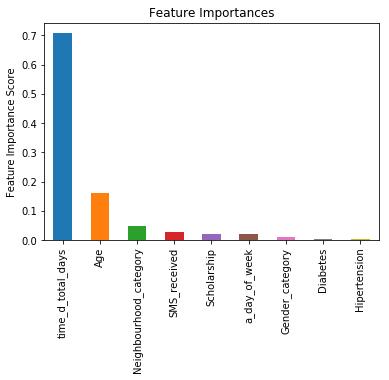

Accuracy =  79.96923912060075
AUC =  0.7186564011244819


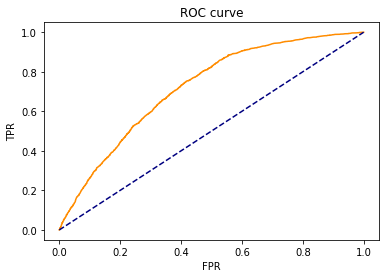

In [56]:
gbm_tuned_1 = GradientBoostingClassifier(n_estimators=20, max_depth=5,min_samples_leaf=70, subsample=0.75,min_samples_split=1100)
modelfit(gbm_tuned_1, dd, feature_set, 'no_show')
plot_roc(gbm_tuned_1, dd, feature_set, 'no_show')
